In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix

from siamese import SiameseNetwork
from tensorpair_test import SiameseTensorPairDataset
from datasets import EvaluateImagePairDataset, EvaluatePairDataset
from eval_metrics import evaluate, plot_roc
from utils import init_evaluate_log, write_csv

import config

In [ ]:
model = SiameseNetwork(backbone="efficientnet")

checkpoint_path = 'runs/efficientnet/bce/efficientnet/best.pt'

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])

In [3]:
def eval_bce(checkpoint_path, test_pairs, tensors):
    out_path = 'eval_results/cnn'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    model = "vgg16"
    csv = f"{out_path}/{model}.csv"
    init_evaluate_log(csv)

    model = SiameseNetwork(backbone=model)
    model.to('cuda')

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("epoch: ", checkpoint['epoch'])

    test_dataset = EvaluateImagePairDataset(test_pairs, tensors, transform='resnet50')
    # test_dataset = EvaluatePairDataset(test_pairs, tensors)
    test_loader = DataLoader(test_dataset, shuffle=False)

    # Lists to store predictions and labels
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for tensor1, tensor2, label, coin1, coin2 in test_loader:
            tensor1, tensor2, label = map(lambda x: x.to('cuda'), [tensor1, tensor2, label])
            label = label.view(-1)

            prob = model(tensor1, tensor2).squeeze(1)

            # Store predictions and labels
            all_preds.extend((prob > 0.5).cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    cm = confusion_matrix(all_labels, all_preds)

    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    false_pr = float(fp/(fp+tn))
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

    write_csv(csv, [accuracy, precision, recall, f1, auc, false_pr, tpr, fpr])

    # Print metrics
    print(f'TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Accuracy (from cm): {(tp+tn)/(tp+tn+fp+fn):.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'FPR: {false_pr:.4f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'AUC: {auc:.3f}')

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

Training with VGG16 backbone
epoch:  11
TP: 1150 | FP: 186 | TN: 1082 | FN: 118
Accuracy: 0.880
Accuracy (from cm): 0.880
Precision: 0.861
Recall: 0.907
FPR: 0.1467
F1 Score: 0.883
AUC: 0.880


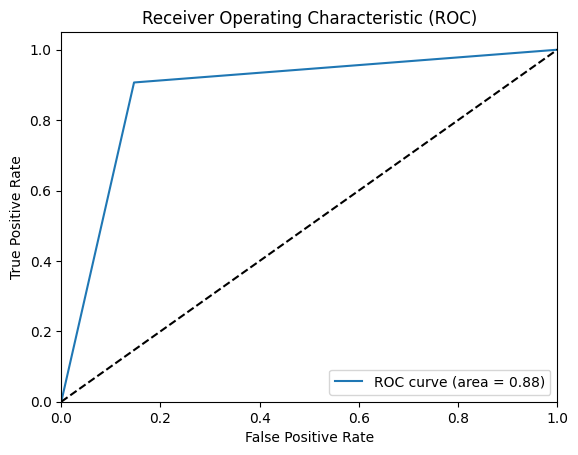

: 

In [4]:
eval_bce(
    'runs/vgg/bce/vgg/best.pt',
    'data/ccc_images/pair/combined/test_dataset.csv',
    'data/ccc_images/data/'
)


In [13]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

from tripletsiamese import SiameseNetwork
from datasets import EvaluateTripletDataset, OfflineTripletDataset
from eval_metrics import evaluate, final_evaluate
from utils import init_evaluate_log, write_csv

import config

In [14]:
def find_triplet_threshold(checkpoint_path, test_pairs, tensors):
    model = SiameseNetwork()
    model.to('cuda')

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("epoch: ", checkpoint['epoch'])

    test_dataset = OfflineTripletDataset(test_pairs, tensors)
    test_loader = DataLoader(test_dataset, shuffle=False)

    # Lists to store predictions and labels
    distances, labels = [], []

    model.eval()
    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor, positive, negative = map(lambda x: x.to('cuda'), [anchor, positive, negative])

            anc_emb, pos_emb, neg_emb = model(anchor, positive, negative)
                
            ap_dist = F.pairwise_distance(anc_emb, pos_emb, p=2)
            an_dist = F.pairwise_distance(anc_emb, neg_emb, p=2)

            distances.extend(ap_dist.cpu().detach().numpy().flatten())
            labels.extend(np.ones(ap_dist.size(0)).flatten())

            distances.extend(an_dist.cpu().detach().numpy().flatten())
            labels.extend(np.zeros(an_dist.size(0)).flatten())

        labels = np.array(labels)
        distances = np.array(distances)

        tpr, fpr, acc, threshold = evaluate(distances, labels)

        print(f"Optimal Threshold: {threshold}")
        print(f"Accuracy: {acc}")

    return threshold

In [17]:
optimal_threshold = find_triplet_threshold(
    'runs/sam/triplet/1i/best.pt',
    'data/ccc_tensors/triplet/combined/val_dataset.csv',
    'data/ccc_tensors/data'
)
# epoch:  38
# Optimal Threshold: 36.43449380494487
# Accuracy: 0.8578066914498141

epoch:  20


Optimal Threshold: 35.64336906434555
Accuracy: 0.8522906793048973


In [ ]:
def eval_triplet(checkpoint_path, test_pairs, tensors):
    out_path = 'eval_results/sam/triplet/1i'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    csv = f"{out_path}/combined.csv"
    init_evaluate_log(csv)

    model = SiameseNetwork()
    model.to('cuda')

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("epoch: ", checkpoint['epoch'])

    test_dataset = EvaluateTripletDataset(test_pairs, tensors)
    test_loader = DataLoader(test_dataset, shuffle=False)

    # Lists to store predictions and labels
    distances, labels = [], []

    model.eval()
    with torch.no_grad():
        for anchor, positive, negative, coin_anchor, coin_positive, coin_negative in test_loader:
            anchor, positive, negative = map(lambda x: x.to('cuda'), [anchor, positive, negative])

            anc_emb, pos_emb, neg_emb = model(anchor, positive, negative)
                
            ap_dist = F.pairwise_distance(anc_emb, pos_emb, p=2)
            an_dist = F.pairwise_distance(anc_emb, neg_emb, p=2)

            distances.extend(ap_dist.cpu().detach().numpy().flatten())
            labels.extend(np.ones(ap_dist.size(0)).flatten())

            distances.extend(an_dist.cpu().detach().numpy().flatten())
            labels.extend(np.zeros(an_dist.size(0)).flatten())

    labels = np.array(labels)
    distances = np.array(distances)

    accuracy, precision, recall, fpr, f1 = final_evaluate(distances, labels, optimal_threshold)

    auc = "na"

    write_csv(csv, [accuracy, precision, recall, f1, auc, fpr, recall, fpr])

    # Print metrics
    # print(f'TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}')
    print(f'Accuracy: {accuracy:.3f}')
    # print(f'Accuracy (from cm): {(tp+tn)/(tp+tn+fp+fn):.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'FPR: {fpr:.4f}')
    print(f'F1 Score: {f1:.3f}')
    

In [ ]:
eval_triplet(
    'runs/sam/triplet/1i/best.pt',
    'data/ccc_tensors/triplet/combined/test_dataset.csv',
    'data/ccc_tensors/data'
)

In [ ]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

from samsiamese import SiameseNetwork
from datasets import EvaluateTripletDataset, OfflineTripletDataset, OfflinePairDataset
from eval_metrics import evaluate, final_evaluate
from utils import init_evaluate_log, write_csv


In [ ]:
def find_contrastive_threshold(checkpoint_path, test_pairs, tensors):
    model = SiameseNetwork(contrastive_loss=True)
    model.to('cuda')

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("epoch: ", checkpoint['epoch'])

    test_dataset = OfflinePairDataset(test_pairs, tensors)
    test_loader = DataLoader(test_dataset, shuffle=False)

    # Lists to store predictions and labels
    distances, labels = [], []

    model.eval()
    with torch.no_grad():
        for tensor1, tensor2, label in test_loader:
            tensor1, tensor2, label = map(lambda x: x.to('cuda'), [tensor1, tensor2, label])
            label = label.view(-1)

            emb1, emb2 = model(tensor1, tensor2)
            
            distance = F.pairwise_distance(emb1, emb2, p=2)

            distances.extend(distance.cpu().detach().numpy().flatten())
            labels.extend(label.cpu().detach().numpy().flatten())


        labels = np.array(labels).flatten()
        distances = np.array(distances).flatten()

        tpr, fpr, acc, threshold = evaluate(distances, labels)

        print(f"Optimal Threshold: {threshold}")
        print(f"Accuracy: {acc}")

    return threshold

In [ ]:
optimal_threshold = find_contrastive_threshold(
    'runs/sam/contrastive/1f/best.pt',
    'data/ccc_tensors/pair/combined/val_dataset.csv',
    'data/ccc_tensors/data'
)

In [ ]:
def eval_contrastive(checkpoint_path, test_pairs, tensors):
    out_path = 'eval_results/sam/contrastive/1f'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    csv = f"{out_path}/combined.csv"
    init_evaluate_log(csv)

    model = SiameseNetwork(contrastive_loss=True)
    model.to('cuda')

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("epoch: ", checkpoint['epoch'])

    test_dataset = OfflinePairDataset(test_pairs, tensors)
    test_loader = DataLoader(test_dataset, shuffle=False)

    # Lists to store predictions and labels
    distances, labels = [], []

    model.eval()
    with torch.no_grad():
        for tensor1, tensor2, label in test_loader:
            tensor1, tensor2, label = map(lambda x: x.to('cuda'), [tensor1, tensor2, label])
            label = label.view(-1)

            emb1, emb2 = model(tensor1, tensor2)
            
            distance = F.pairwise_distance(emb1, emb2, p=2)

            distances.extend(distance.cpu().detach().numpy().flatten())
            labels.extend(label.cpu().detach().numpy().flatten())


        labels = np.array(labels).flatten()
        distances = np.array(distances).flatten()

    accuracy, precision, recall, fpr, f1 = final_evaluate(distances, labels, optimal_threshold)

    # accuracy = float((tp + tn) / (tp + tn + fp + fn))
    # precision = float(tp / (tp + fp))
    # recall = float(tp / (tp + fn))
    # f1 = float((2 * precision * recall) / (precision + recall))
    # fpr = float(fp/(fp+tn))
    # auc = roc_auc_score(all_labels, all_preds)
    auc = "na"

    write_csv(csv, [accuracy, precision, recall, f1, auc, fpr, recall, fpr])

    # Print metrics
    # print(f'TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}')
    print(f'Accuracy: {accuracy:.3f}')
    # print(f'Accuracy (from cm): {(tp+tn)/(tp+tn+fp+fn):.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'FPR: {fpr:.4f}')
    print(f'F1 Score: {f1:.3f}')
    

In [ ]:
eval_contrastive(
    'runs/sam/contrastive/1f/best.pt',
    'data/ccc_tensors/pair/combined/test_dataset.csv',
    'data/ccc_tensors/data'
)